# Search Testing

In [1]:
# Want to be able to reload changed modules on the fly
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

import src.search
from src.data import load_metadata, find_paths

import src.utils
src.utils.gpu_setup()

4 actual GPUs, 1 in use.


## 1) Set up the searcher

In [3]:
%%time
# Set up the searcher
searcher = src.search.Searcher("../config.yaml")

CPU times: user 9.1 s, sys: 735 ms, total: 9.83 s
Wall time: 12 s


## 2) Define the queries to test

In [4]:
# Setup the queries to test on...
queries = [
    {"title": "trump call ukrainian", "desc": "The White House released a rough transcript of President Donald Trump’s phone call with the Ukrainian President in November 2019. What were people saying about the conversation in the call? News items about the call are relevant."},
    {"title": "near death experiences", "desc": "I wonder if people have shared near-death experiences in podcast episodes.  I would like to find and listen to some stories.  I am not interested in the science of near-death experiences."},
    {"title": "black lives matter", "desc": "What do people mean when they say “black lives matter”?  I am interested in personal reflections that give context to the phrase “black lives matter” and why it is important to individuals.  News stores about Black Lives Matter protests are relevant as well."},
    {"title": "halloween stories and chat", "desc": "I love Halloween and I want to hear stories and conversations about things people have done to celebrate it.  I am not looking for information about the history of Halloween or generalities about how it is celebrated, I want specific stories from individuals."},
    {"title": "workplace diversity", "desc": "What are things companies are doing and could do to promote diversity in the workplace?  Things like workplace programs, initiatives, education, and outreach are relevant.  Discussion about the outcomes of these efforts are relevant as well."},
]

## 3) Run a query and explore the output

In [5]:
query_num = 1
search_df = searcher.search(queries[query_num]["title"], queries[query_num]["desc"])

Running Elasticsearch query... returned 100 segments in 0.36 seconds
Getting rerank scores for segments... returned 100 scores in 20.59 seconds
Getting audio scores for 74 segments... 


100%|██████████| 74/74 [13:17<00:00, 10.77s/it]
/unix/cdtdisspotify/jtingey/podcast-dataset/src/search/features.py:26: RuntimeWarning: divide by zero encountered in power
  return beta**alpha/gamma(alpha) * x.T**(alpha-1) * np.exp(-beta*x.T)
/unix/cdtdisspotify/jtingey/podcast-dataset/src/search/features.py:31: RuntimeWarning: invalid value encountered in true_divide
  return (p/np.sum(p,axis=0)).T
/unix/cdtdisspotify/jtingey/podcast-dataset/src/search/features.py:46: RuntimeWarning: invalid value encountered in true_divide
  return (p/np.sum(p,axis=0)).T


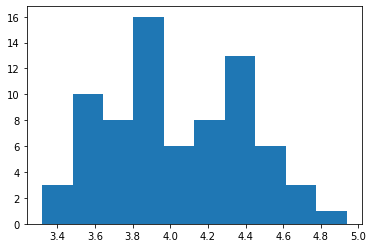

In [6]:
# SHOULD MAKE DISTRIBUTION PLOTS FOR THE FEATURES FROM LOTS OF PODCASTS!
plt.hist(search_df["opensmile_disapproval"])
plt.show()

In [7]:
search_df[['show_name', 'epis_name', 'seg_speakers', 'es_score', 'rerank_score', 'laughter_freq', 'music_freq', 'conversation_freq', 'narration_freq', 'yamnet_funny', 'yamnet_conversation', 'opensmile_debate', 'opensmile_disapproval']]

,show_name,epis_name,seg_speakers,es_score,rerank_score,laughter_freq,music_freq,conversation_freq,narration_freq,yamnet_funny,yamnet_conversation,opensmile_debate,opensmile_disapproval
0,The Death Dialogues Project Podcast,31. Tricia Barker shares her Near Death Experi...,1,139.722240,3.793441,0,79,0,8,0.000000,2.491007e-02,17.403510,4.214363
1,A Private Service Announcement,Do it for the ‘Gram (I nearly died) // PSA 003...,2,137.614720,3.856227,0,88,0,62,0.000000,7.639865e-01,11.707335,3.318950
2,Matt D’Elia Is Confused,Dr. Eben Alexander | The Near Death Experience,1,132.199190,3.470416,0,7,2,96,0.000000,7.639865e-01,29.136465,4.218578
3,Matt D’Elia Is Confused,Dr. Eben Alexander | The Near Death Experience,1,129.997330,3.536778,0,0,1,102,0.000000,7.639865e-01,28.057964,4.242487
4,The Death Dialogues Project Podcast,31. Tricia Barker shares her Near Death Experi...,2,129.844330,3.092210,1,0,5,94,0.000000,2.491007e-02,19.999614,4.467983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Bigfoot Collectors Club,BCC 60 - “The Grafton Monster” w/ Jack Plotnick!,3,96.479010,2.582076,0,1,0,44,0.000000,7.639865e-01,19.150416,3.587250
70,Bigfoot Collectors Club,BCC 60 - “The Grafton Monster” w/ Jack Plotnick!,3,96.445750,2.977291,1,2,1,59,0.000000,7.639865e-01,18.114733,3.512196
71,Project Mindfulness Podcast,Train your Brain for Happiness with Dana Wilde,2,96.425280,2.522410,0,57,4,88,0.000000,1.350191e-04,12.256869,3.588428
72,The Death Dialogues Project Podcast,31. Tricia Barker shares her Near Death Experi...,2,96.401400,2.840199,1,0,4,85,0.597695,2.500095e-16,16.506109,4.350810


In [8]:
topical_ids = searcher.rerank_topical(search_df)
entertaining_ids = searcher.rerank_entertaining(search_df)
subjective_ids = searcher.rerank_subjective(search_df)
discussion_ids = searcher.rerank_discussion(search_df)

In [ ]:
# First highest topical score
print(topical_ids[0])
waveform = searcher.get_segment_audio(topical_ids[0])
Audio(waveform, rate=44100)

In [ ]:
# Second highest topical score
print(topical_ids[1])
waveform = searcher.get_segment_audio(topical_ids[1])
Audio(waveform, rate=44100)

In [ ]:
# First highest entertaining score
print(entertaining_ids[0])
waveform = searcher.get_segment_audio(entertaining_ids[0])
Audio(waveform, rate=44100)

In [ ]:
# Second highest entertaining score
print(entertaining_ids[1])
waveform = searcher.get_segment_audio(entertaining_ids[1])
Audio(waveform, rate=44100)

In [ ]:
# First highest subjective score
print(subjective_ids[0])
waveform = searcher.get_segment_audio(subjective_ids[0])
Audio(waveform, rate=44100)

In [ ]:
# Second highest subjective score
print(subjective_ids[1])
waveform = searcher.get_segment_audio(subjective_ids[1])
Audio(waveform, rate=44100)

In [ ]:
# First highest discussion score
print(discussion_ids[0])
waveform = searcher.get_segment_audio(discussion_ids[0])
Audio(waveform, rate=44100)

In [ ]:
# Second highest discussion score
print(discussion_ids[1])
waveform = searcher.get_segment_audio(discussion_ids[1])
Audio(waveform, rate=44100)